In [3]:
import pandas as pd
import geopandas as gpd
from scipy.stats import kde
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import glob
import matplotlib.dates as mdates
from scipy import stats
from scipy.stats import pearsonr


from utils.util_functions import *

%load_ext autoreload
%autoreload 2

/Users/juanolmos/opt/anaconda3/envs/dl/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


Util info: 

``ID_1`` (Guarda los ID de los segmentos, acá estos ID ya son diferentes direcciones y velocidades).

``Road_right`` (Es el corredor)

## Util functions:



In [4]:
def filter_intersection(df):
    return df[df["Road_right"].notna()] #datos en los cuales hay interseccion y quedan con esta caracteristica vacia

def filterANDchange_speed(df):    
    df["speed"] = df["speed"]*3.6 #conversion de m/s a km/h
    
    # df = df[df["speed"]>4]
    df = df[(df["speed"] > 15) & (df["speed"] < 150)] #filtrado de datos con velocidad 
    return df

def filters(df):
    df = df[~df["local_location_at"].str.contains("|".join(festivos2022))] #Quitando festivos
    df = df[df["horizontal_accuracy"] < 10]
    return df

def corr_plot(x_data, y_data, xlabel = None, ylabel = None, title = None):
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    ax.scatter(x=x_data, y=y_data, alpha= 0.3)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if title is not None:   
        ax.set_title(title)
    maxarr = np.max(list(x_data)+list(y_data))
    xx = np.linspace(0,maxarr)
    plt.plot(xx,xx, c = 'r')
    # plt.loglog()
    
  
    
festivos2022 = ["2021-12-31","2022-01-01", "2022-01-10", "2022-03-21", "2022-04-14", "2022-04-15"]    
    
name = dict({"Bolivar_Valledupar": "Bolivar - Valledupar",
             "Briceno_Tunja_Sogamoso": "Briceño - Tunja - Sogamoso",
             "Cienaga_San_Roque": "Cienaga - San Roque"})

In [11]:
#Shape file (see data folder)
geodf_buffer = gpd.GeoDataFrame.from_file("../../../shared_speeds_wbg/buffer_without_overlaps/buffer_without_overlaps.shp")

Una vez leido el buffer, vamos a tomar los puntos de cada dia de enero e intersectarlos con el buffer. Nos quedamos con la interseccion. Todas las intersecciones quedaran almacenadas en df

In [14]:
lens_intersection, lens_speed_val = [], []
sum_before_buffer, sum_after_buffer = 0, 0
for i, path_df in enumerate(sorted(glob.glob("../../outlogic_allcorridors/2022*.csv"))):
    df_orig, df = get_df_in_buffer(path_df = path_df, geodf_buffer = geodf_buffer, get_orig = True) # load buffer
    df = filter_intersection(df)    
    lens_intersection.append(len(df))

    df = filterANDchange_speed(df) # change scale of the speed 
    df = filters(df) #festivos, horizontal accuracy
    lens_speed_val.append(len(df))
    
    if i > 0:
        df = pd.concat([df,df_ant])
        df_ant = df
        
        df_orig = pd.concat([df_orig,df_orig_ant])
        df_orig_ant = df_orig
        
    else:
        df_ant = df
        df_orig_ant = df_orig
    
df.loc[:,'local_location_at'] = df['local_location_at'].apply(lambda x: x[:-4])    

/Users/juanolmos/Library/CloudStorage/GoogleDrive-juandolmos63@gmail.com/My Drive/TRABAJO/shared_olmos_consultoria/colombia_speeds/code/2022_colombia_speed_roads/utils/util_functions.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df_in_buffer = gpd.sjoin(df_geo, geodf_buffer)
/Users/juanolmos/Library/CloudStorage/GoogleDrive-juandolmos63@gmail.com/My Drive/TRABAJO/shared_olmos_consultoria/colombia_speeds/code/2022_colombia_speed_roads/utils/util_functions.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df_in_buffer = gpd.sjoin(df_geo, geodf_buffer)
/Users/juanolmos/Library/CloudStorage/GoogleDrive-juandolmos63@gmail.com/My Drive/TR

In [17]:
print(len(df_orig)) #total 
print(len(df)) #With filters

4267459
1193850


In [19]:
len(df["device_id"].unique())

13310

In [9]:
# df_orig.to_csv("outputs/df_orig.csv", index = False)

In [10]:
# df.to_csv("outputs/df_in_buffer.csv", index = False)

In [5]:
df = pd.read_csv("outputs/df_in_buffer.csv")

/Users/juanolmos/opt/anaconda3/envs/dl/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'device_id', 'platform', 'timestamp',
       'local_location_at', 'latitude', 'longitude', 'iso_region',
       'horizontal_accuracy', 'speed', 'user_agent', 'carrier', 'device_model',
       'geometry', 'id_left', 'Country_left', 'Road_left', 'index_right',
       'id_right', 'Country_right', 'Road_right', 'Length', 'START_X',
       'START_Y', 'END_X', 'END_Y', 'ID_1', 'Area', 'location_dt'],
      dtype='object')

In [7]:
df

,Unnamed: 0,Unnamed: 0.1,device_id,platform,timestamp,local_location_at,latitude,longitude,iso_region,horizontal_accuracy,...,Country_right,Road_right,Length,START_X,START_Y,END_X,END_Y,ID_1,Area,location_dt
0,104,759,d581a938c7c2b0b201d6d5cc2b5775adc6f22265e1826b...,AAID,2022-04-21 12:54:01+00:00,2022-04-21 07:54:01,5.765943,-72.971240,CO-BOY,1.4,...,Colombia,Briceno_Tunja_Sogamoso,4893.849,-72.939896,5.753012,-72.972518,5.768947,196,37469.780716,NaN
1,43545,4991,b12fe89c72dd75edc71cf448683103a077ef24026648bb...,AAID,2022-04-21 23:53:55+00:00,2022-04-21 18:53:55,5.756564,-72.967430,CO-BOY,5.7,...,Colombia,Briceno_Tunja_Sogamoso,4893.849,-72.939896,5.753012,-72.972518,5.768947,196,37469.780716,NaN
2,45689,10019,418a934d5f49cd24052757575f540610cd316e39bfd710...,IDFA,2022-04-21 21:59:45+00:00,2022-04-21 16:59:45,5.767820,-72.972010,CO-BOY,4.7,...,Colombia,Briceno_Tunja_Sogamoso,4893.849,-72.939896,5.753012,-72.972518,5.768947,196,37469.780716,NaN
3,120887,6885,8656073075e8ff9cc53459694fdd7c5fb54074bdcf1864...,AAID,2022-04-21 21:17:08+00:00,2022-04-21 16:17:08,5.762593,-72.969930,CO-BOY,1.9,...,Colombia,Briceno_Tunja_Sogamoso,4893.849,-72.939896,5.753012,-72.972518,5.768947,196,37469.780716,NaN
4,135658,6209,1b82761fe0aeb548f1643cc57a3f0ba81917f881488f5d...,AAID,2022-04-21 12:29:08+00:00,2022-04-21 07:29:08,5.751986,-72.962540,CO-BOY,1.5,...,Colombia,Briceno_Tunja_Sogamoso,4893.849,-72.939896,5.753012,-72.972518,5.768947,196,37469.780716,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193845,1257412,2230,f7cca1c4d8d071e7f53f3c24a17328a886c5c9e5ef5541...,AAID,2022-01-02 19:20:59+00:00,2022-01-02 14:20:59,9.393563,-73.539290,CO-CES,9.9,...,Colombia,Cienaga_San_Roque,5226.661,-73.532785,9.370922,-73.545969,9.416322,54,39490.927703,2022-01-02
1193846,1339771,881,f7cca1c4d8d071e7f53f3c24a17328a886c5c9e5ef5541...,AAID,2022-01-02 19:21:46+00:00,2022-01-02 14:21:46,9.384047,-73.536480,CO-CES,9.9,...,Colombia,Cienaga_San_Roque,5226.661,-73.532785,9.370922,-73.545969,9.416322,54,39490.927703,2022-01-02
1193847,1222344,1884,752972f0e240d8c8af1eda7c31415f7a23b6b0692e849a...,AAID,2022-01-02 20:26:27+00:00,2022-01-02 15:26:27,10.083408,-73.732540,CO-CES,4.0,...,Colombia,Bolivar_Valledupar,429.115,-73.732051,10.084953,-73.733225,10.081255,333,5911.769890,2022-01-02
1193848,1326618,2118,e2ae6e4f8d11dd2b378e53a95d3c44533cdac232498c5c...,AAID,2022-01-02 16:16:46+00:00,2022-01-02 11:16:46,9.867915,-74.563240,CO-MAG,3.8,...,Colombia,Bolivar_Valledupar,2496.697,-74.574498,9.873062,-74.555263,9.862772,246,19540.767922,2022-01-02


In [8]:
# Number of segments on each corridor
for r in df["Road_right"].unique():
    print(r)
    print(len(df[df["Road_right"] == r]["ID_1"].unique()))


Briceno_Tunja_Sogamoso
98
Bolivar_Valledupar
136
Cienaga_San_Roque
102


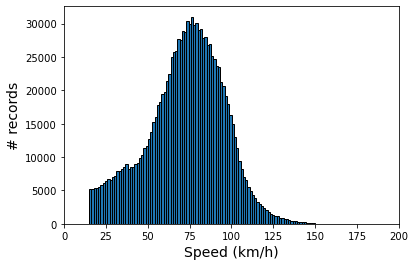

In [35]:

plt.hist(df["speed"], edgecolor = "black", bins=100)
# plt.yscale("log")
plt.xlabel("Speed (km/h)", fontsize=14)
plt.ylabel("# records", fontsize=14)
plt.xlim(0,200)
plt.savefig("outputs/2022_11_informe/speed_hist.png", dpi=200, bbox_inches="tight")
plt.show()

In [9]:
# Manipulando dates

df.loc[:,'date_1']=df['local_location_at'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #convert str to timestamp
df['date_15min'] = df['date_1'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour, 15*(dt.minute // 15)))
df['date_30min'] = df['date_1'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour, 30*(dt.minute // 30)))
df['date_3h'] = df['date_1'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, 3*(dt.hour // 3)))
df['date_1h'] = df['date_1'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour ))
df["date_month_day"] = df['date_1'].apply(lambda dt: datetime(dt.year, dt.month, dt.day))

columna_filtrar_tiempos = "date_3h"

df["hourTimeStamp"] = df[columna_filtrar_tiempos].dt.hour
df["dayTimeStamp"] = df[columna_filtrar_tiempos].dt.day
df["day_name"] = df[columna_filtrar_tiempos].dt.day_name()
df["day_type"] = df["day_name"].apply(lambda x: "weekday" if x not in ["Saturday", "Sunday"] else "weekend")

df.head()
# df["local_location_at"].hist()

,Unnamed: 0,Unnamed: 0.1,device_id,platform,timestamp,local_location_at,latitude,longitude,iso_region,horizontal_accuracy,...,date_1,date_15min,date_30min,date_3h,date_1h,date_month_day,hourTimeStamp,dayTimeStamp,day_name,day_type
0,104,759,d581a938c7c2b0b201d6d5cc2b5775adc6f22265e1826b...,AAID,2022-04-21 12:54:01+00:00,2022-04-21 07:54:01,5.765943,-72.97124,CO-BOY,1.4,...,2022-04-21 07:54:01,2022-04-21 07:45:00,2022-04-21 07:30:00,2022-04-21 06:00:00,2022-04-21 07:00:00,2022-04-21,6,21,Thursday,weekday
1,43545,4991,b12fe89c72dd75edc71cf448683103a077ef24026648bb...,AAID,2022-04-21 23:53:55+00:00,2022-04-21 18:53:55,5.756564,-72.96743,CO-BOY,5.7,...,2022-04-21 18:53:55,2022-04-21 18:45:00,2022-04-21 18:30:00,2022-04-21 18:00:00,2022-04-21 18:00:00,2022-04-21,18,21,Thursday,weekday
2,45689,10019,418a934d5f49cd24052757575f540610cd316e39bfd710...,IDFA,2022-04-21 21:59:45+00:00,2022-04-21 16:59:45,5.767820,-72.97201,CO-BOY,4.7,...,2022-04-21 16:59:45,2022-04-21 16:45:00,2022-04-21 16:30:00,2022-04-21 15:00:00,2022-04-21 16:00:00,2022-04-21,15,21,Thursday,weekday
3,120887,6885,8656073075e8ff9cc53459694fdd7c5fb54074bdcf1864...,AAID,2022-04-21 21:17:08+00:00,2022-04-21 16:17:08,5.762593,-72.96993,CO-BOY,1.9,...,2022-04-21 16:17:08,2022-04-21 16:15:00,2022-04-21 16:00:00,2022-04-21 15:00:00,2022-04-21 16:00:00,2022-04-21,15,21,Thursday,weekday
4,135658,6209,1b82761fe0aeb548f1643cc57a3f0ba81917f881488f5d...,AAID,2022-04-21 12:29:08+00:00,2022-04-21 07:29:08,5.751986,-72.96254,CO-BOY,1.5,...,2022-04-21 07:29:08,2022-04-21 07:15:00,2022-04-21 07:00:00,2022-04-21 06:00:00,2022-04-21 07:00:00,2022-04-21,6,21,Thursday,weekday


In [10]:
df = df[(df["hourTimeStamp"] > 3) & (df["hourTimeStamp"] < 21)] # 6am-9pm
df

,Unnamed: 0,Unnamed: 0.1,device_id,platform,timestamp,local_location_at,latitude,longitude,iso_region,horizontal_accuracy,...,date_1,date_15min,date_30min,date_3h,date_1h,date_month_day,hourTimeStamp,dayTimeStamp,day_name,day_type
0,104,759,d581a938c7c2b0b201d6d5cc2b5775adc6f22265e1826b...,AAID,2022-04-21 12:54:01+00:00,2022-04-21 07:54:01,5.765943,-72.971240,CO-BOY,1.4,...,2022-04-21 07:54:01,2022-04-21 07:45:00,2022-04-21 07:30:00,2022-04-21 06:00:00,2022-04-21 07:00:00,2022-04-21,6,21,Thursday,weekday
1,43545,4991,b12fe89c72dd75edc71cf448683103a077ef24026648bb...,AAID,2022-04-21 23:53:55+00:00,2022-04-21 18:53:55,5.756564,-72.967430,CO-BOY,5.7,...,2022-04-21 18:53:55,2022-04-21 18:45:00,2022-04-21 18:30:00,2022-04-21 18:00:00,2022-04-21 18:00:00,2022-04-21,18,21,Thursday,weekday
2,45689,10019,418a934d5f49cd24052757575f540610cd316e39bfd710...,IDFA,2022-04-21 21:59:45+00:00,2022-04-21 16:59:45,5.767820,-72.972010,CO-BOY,4.7,...,2022-04-21 16:59:45,2022-04-21 16:45:00,2022-04-21 16:30:00,2022-04-21 15:00:00,2022-04-21 16:00:00,2022-04-21,15,21,Thursday,weekday
3,120887,6885,8656073075e8ff9cc53459694fdd7c5fb54074bdcf1864...,AAID,2022-04-21 21:17:08+00:00,2022-04-21 16:17:08,5.762593,-72.969930,CO-BOY,1.9,...,2022-04-21 16:17:08,2022-04-21 16:15:00,2022-04-21 16:00:00,2022-04-21 15:00:00,2022-04-21 16:00:00,2022-04-21,15,21,Thursday,weekday
4,135658,6209,1b82761fe0aeb548f1643cc57a3f0ba81917f881488f5d...,AAID,2022-04-21 12:29:08+00:00,2022-04-21 07:29:08,5.751986,-72.962540,CO-BOY,1.5,...,2022-04-21 07:29:08,2022-04-21 07:15:00,2022-04-21 07:00:00,2022-04-21 06:00:00,2022-04-21 07:00:00,2022-04-21,6,21,Thursday,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193845,1257412,2230,f7cca1c4d8d071e7f53f3c24a17328a886c5c9e5ef5541...,AAID,2022-01-02 19:20:59+00:00,2022-01-02 14:20:59,9.393563,-73.539290,CO-CES,9.9,...,2022-01-02 14:20:59,2022-01-02 14:15:00,2022-01-02 14:00:00,2022-01-02 12:00:00,2022-01-02 14:00:00,2022-01-02,12,2,Sunday,weekend
1193846,1339771,881,f7cca1c4d8d071e7f53f3c24a17328a886c5c9e5ef5541...,AAID,2022-01-02 19:21:46+00:00,2022-01-02 14:21:46,9.384047,-73.536480,CO-CES,9.9,...,2022-01-02 14:21:46,2022-01-02 14:15:00,2022-01-02 14:00:00,2022-01-02 12:00:00,2022-01-02 14:00:00,2022-01-02,12,2,Sunday,weekend
1193847,1222344,1884,752972f0e240d8c8af1eda7c31415f7a23b6b0692e849a...,AAID,2022-01-02 20:26:27+00:00,2022-01-02 15:26:27,10.083408,-73.732540,CO-CES,4.0,...,2022-01-02 15:26:27,2022-01-02 15:15:00,2022-01-02 15:00:00,2022-01-02 15:00:00,2022-01-02 15:00:00,2022-01-02,15,2,Sunday,weekend
1193848,1326618,2118,e2ae6e4f8d11dd2b378e53a95d3c44533cdac232498c5c...,AAID,2022-01-02 16:16:46+00:00,2022-01-02 11:16:46,9.867915,-74.563240,CO-MAG,3.8,...,2022-01-02 11:16:46,2022-01-02 11:15:00,2022-01-02 11:00:00,2022-01-02 09:00:00,2022-01-02 11:00:00,2022-01-02,9,2,Sunday,weekend


[]

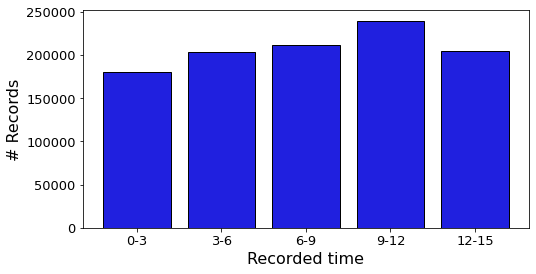

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.countplot( x = df["hourTimeStamp"], color = "b", edgecolor = "k", ax=ax)
plt.xticks(np.arange(8),["0-3","3-6","6-9","9-12","12-15","15-18","18-21","21-24"], fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Recorded time", fontsize=16)
plt.ylabel("# Records", fontsize=16)
# plt.savefig("outputs/2022_11_informe/numRecords_segmentDay.png", dpi=200, bbox_inches="tight")
plt.plot()

[]

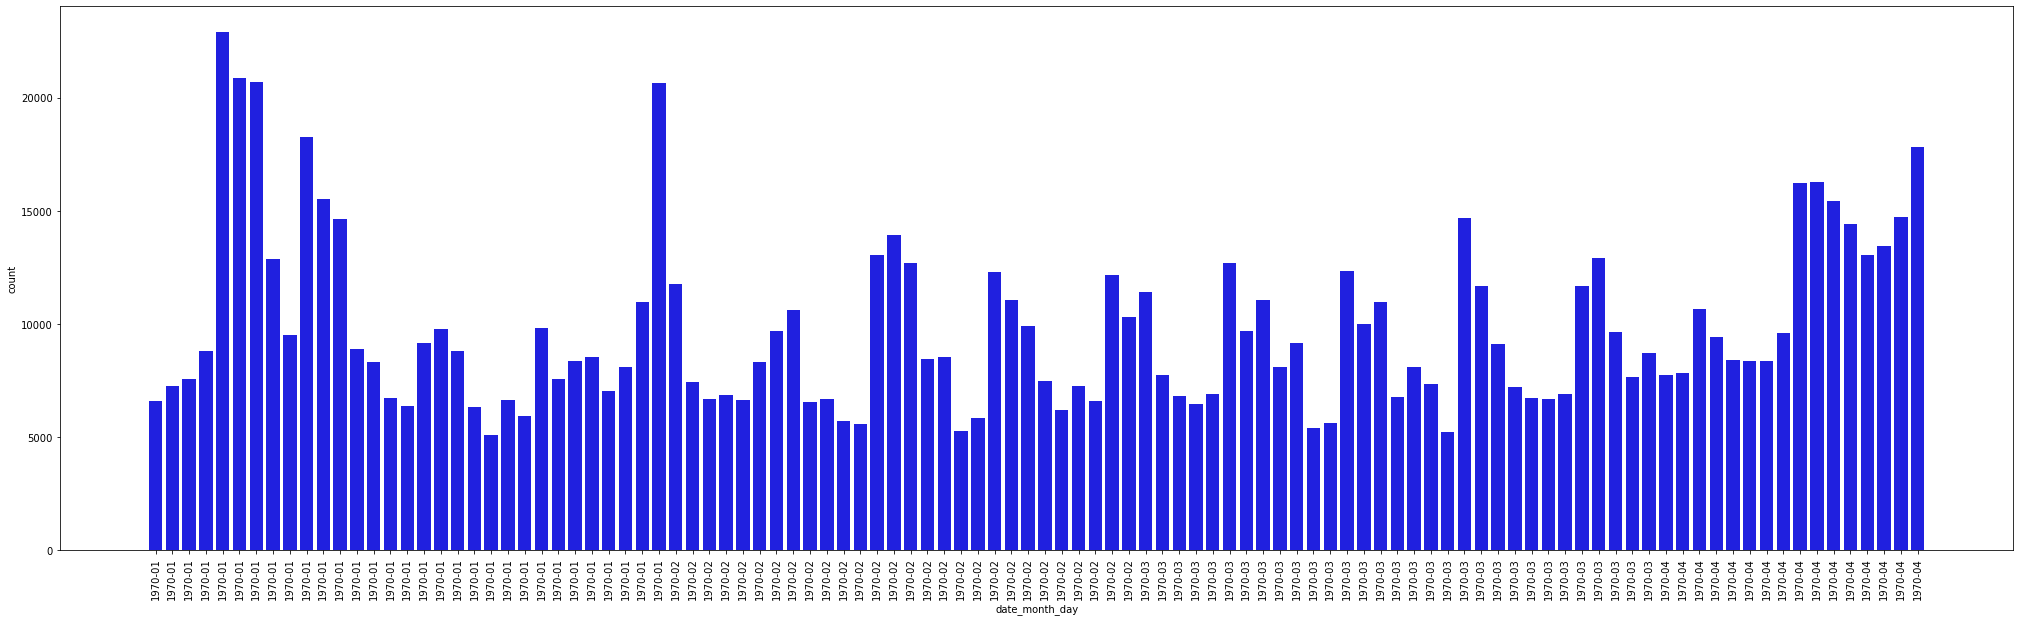

In [39]:
fig, ax = plt.subplots(figsize=(35,10))
sns.countplot( x = df["date_month_day"], color = "b")
plt.xticks(rotation = 90)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.plot()


In [42]:
#To analize the data per device per range of the day
df_freq_id = df.copy()
df_freq_id["count"] = 1

# speed average, and recrods per user in each road 
df_freq_id = df_freq_id.groupby(["Road_right","ID_1","device_id","date_3h"]).agg(
    speed = ("speed",stats.hmean),
    speed_std = ("speed", "std"),
    count = ("count","sum")
    ).reset_index()

display(df_freq_id.head())
print(len(df_freq_id))

,Road_right,ID_1,device_id,date_3h,speed,speed_std,count
0,Bolivar_Valledupar,201,0031709b6c79a24e8b4a4b92e54e473f3eb9455382043f...,2022-01-15 09:00:00,55.540874,2.459723,2
1,Bolivar_Valledupar,201,00508c9c589b7b3f71efd504f4680272f74423b7d17bbc...,2022-02-04 09:00:00,51.994008,NaN,1
2,Bolivar_Valledupar,201,007ec1dd050074faa972bb9c3746a92306d744c1c6305d...,2022-01-09 15:00:00,28.764000,NaN,1
3,Bolivar_Valledupar,201,0371bc9d3ce92931618a39fad0fc6afd0f6444ee62b2e4...,2022-01-03 06:00:00,70.638758,16.684372,3
4,Bolivar_Valledupar,201,078a816b6625d7ff759bab768e7d9b440ddd31efb5f63a...,2022-02-11 12:00:00,43.632000,NaN,1


349446


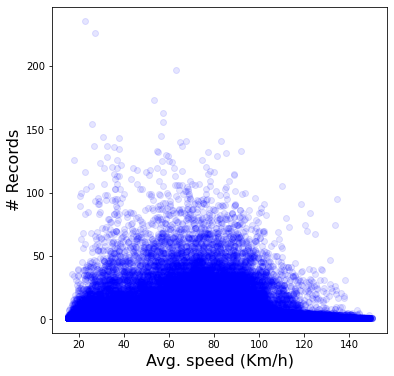

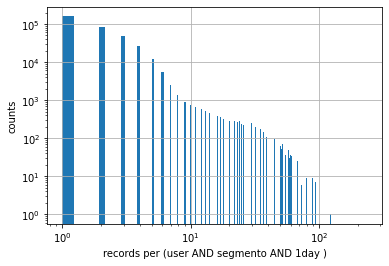

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.scatter(df_freq_id["speed"], df_freq_id["count"], alpha=0.1, color = 'b', edgecolor = 'b')
# plt.yticks(fontsize=13)
plt.xlabel("Avg. speed (Km/h)", fontsize=16)
plt.ylabel("# Records", fontsize=16)
# plt.savefig("outputs/2022_11_informe/speed_vs_numRecords.png", dpi=200, bbox_inches="tight")
plt.show()

#Plotting histogram records
df_freq_id["count"].hist(bins = 1000)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("records per (user AND segmento AND 1day )")
plt.ylabel("counts")
plt.show()


In [41]:
# Guardando los raramente frecuentes
# df_freq_id[df_freq_id["count"] < 10].merge(df, on="device_id", how="left").to_csv("df_freq_id_raramente_frecuente.csv", index = False)

/var/folders/vk/14ym66kj4_d9xkr_w6f6cr7w0000gn/T/ipykernel_40328/3122995255.py:4: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  density = kde.gaussian_kde(counts['counts'])


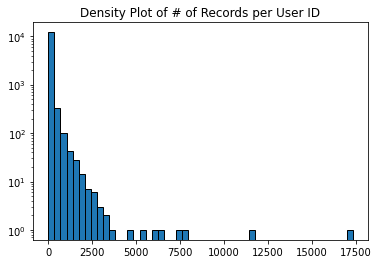

In [44]:
# Contando cantidad de datos por usuario
counts = df['device_id'].value_counts().rename_axis('unique_values').reset_index(name='counts')

density = kde.gaussian_kde(counts['counts'])
x = np.linspace(0,max(counts['counts']),300)
y = density(x)

plt.hist(counts['counts'],bins=50, edgecolor='black')  
plt.title("Density Plot of # of Records per User ID")

# plt.xlabel("Number of Records")
# plt.xscale('log')
plt.yscale('log')
# plt.savefig("outputs/2022_11_informe/numRecords_perUser.png", dpi=200, bbox_inches="tight")
plt.show()

Text(0, 0.5, 'Frequency')

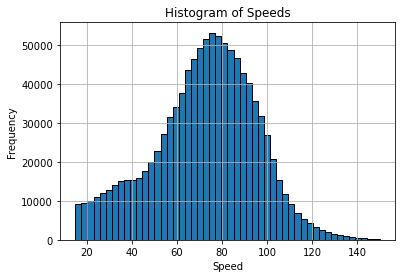

In [45]:
df['speed'].hist(bins=50, edgecolor = 'black')
plt.title("Histogram of Speeds")
plt.xlabel("Speed")
plt.ylabel("Frequency")

In [11]:
df2 = df[["device_id","speed","Road_right","ID_1","date_1","dayTimeStamp","hourTimeStamp","date_3h"]]
df2

,device_id,speed,Road_right,ID_1,date_1,dayTimeStamp,hourTimeStamp,date_3h
0,d581a938c7c2b0b201d6d5cc2b5775adc6f22265e1826b...,91.152000,Briceno_Tunja_Sogamoso,196,2022-04-21 07:54:01,21,6,2022-04-21 06:00:00
1,b12fe89c72dd75edc71cf448683103a077ef24026648bb...,69.343204,Briceno_Tunja_Sogamoso,196,2022-04-21 18:53:55,21,18,2022-04-21 18:00:00
2,418a934d5f49cd24052757575f540610cd316e39bfd710...,61.884000,Briceno_Tunja_Sogamoso,196,2022-04-21 16:59:45,21,15,2022-04-21 15:00:00
3,8656073075e8ff9cc53459694fdd7c5fb54074bdcf1864...,49.127177,Briceno_Tunja_Sogamoso,196,2022-04-21 16:17:08,21,15,2022-04-21 15:00:00
4,1b82761fe0aeb548f1643cc57a3f0ba81917f881488f5d...,57.564000,Briceno_Tunja_Sogamoso,196,2022-04-21 07:29:08,21,6,2022-04-21 06:00:00
...,...,...,...,...,...,...,...,...
1193845,f7cca1c4d8d071e7f53f3c24a17328a886c5c9e5ef5541...,80.064000,Cienaga_San_Roque,54,2022-01-02 14:20:59,2,12,2022-01-02 12:00:00
1193846,f7cca1c4d8d071e7f53f3c24a17328a886c5c9e5ef5541...,106.308000,Cienaga_San_Roque,54,2022-01-02 14:21:46,2,12,2022-01-02 12:00:00
1193847,752972f0e240d8c8af1eda7c31415f7a23b6b0692e849a...,49.536000,Bolivar_Valledupar,333,2022-01-02 15:26:27,2,15,2022-01-02 15:00:00
1193848,e2ae6e4f8d11dd2b378e53a95d3c44533cdac232498c5c...,72.036000,Bolivar_Valledupar,246,2022-01-02 11:16:46,2,9,2022-01-02 09:00:00


# Comparison with Mapbox (time-slot)

In [36]:
df_dis = get_all_dis()

df_dis.loc[:,'date_1']=df_dis['timestamp'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #convert str to timestamp
df_dis['date_3h'] = df_dis['date_1'].apply(lambda dt: datetime(dt.year, dt.month, dt.day, 3*(dt.hour // 3)))

df_dis["hourTimeStamp"] = df_dis["date_3h"].dt.hour

df_dis = df_dis.groupby(["id","hourTimeStamp"]).agg(
    speed = ("speed","mean"),
    # speed = ("speed", percentile(85)),
    speed_std = ("speed","std")).reset_index()


df_dis = df_dis[(df_dis["speed"].notna()) & (df_dis["speed"] < 150) & (df_dis["speed"] >15)] #Pues hay velocidades muy altas, ej: id 135 el 07-05 de 2022
df_dis = df_dis[df_dis["speed_std"] < 20]
    
# MERGE INDICES DISAGGREGATED-V2V3
df_v2v3 = pd.read_csv("../../idv2_idv3.csv") # id_2 Road_2 son las columnas de los segmentos que estamos analizando
df_dis = df_dis.merge(df_v2v3, left_on = "id", right_on = "id")[["id_2","hourTimeStamp","speed","speed_std"]]
df_dis["id_2"] = df_dis["id_2"].astype(str)


df_dis 


,id_2,hourTimeStamp,speed,speed_std
0,1,3,44.588563,14.827416
1,103,3,44.588563,14.827416
2,201,3,44.588563,14.827416
3,1,6,44.208292,14.106949
4,103,6,44.208292,14.106949
...,...,...,...,...
1524,336,9,28.831285,1.748372
1525,336,12,29.376195,1.970395
1526,336,15,26.645643,4.164582
1527,336,18,24.924042,3.034513


15.00480936
149.976


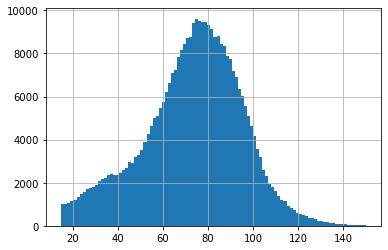

15.012
149.94


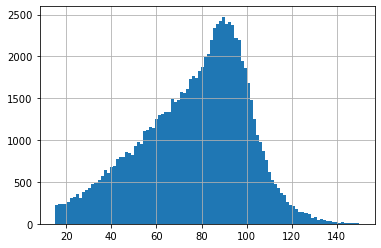

,Road_right,ID_1,hourTimeStamp,speed,speed_std
0,Bolivar_Valledupar,201,6,52.892692,16.091559
1,Bolivar_Valledupar,201,9,56.372326,12.720014
2,Bolivar_Valledupar,201,12,48.165407,15.234011
3,Bolivar_Valledupar,201,15,46.846176,16.440726
4,Bolivar_Valledupar,201,18,50.790692,16.467333
...,...,...,...,...,...
1664,Cienaga_San_Roque,102,6,61.534158,10.552299
1665,Cienaga_San_Roque,102,9,61.983234,11.436989
1666,Cienaga_San_Roque,102,12,64.322756,10.648465
1667,Cienaga_San_Roque,102,15,64.980970,9.842890


In [37]:
df_mean_speeds_id = df2.groupby(["Road_right","device_id","ID_1","date_3h","hourTimeStamp"]).agg(
    speed = ("speed","mean"),
    speed_std = ("speed","std")).reset_index()

# df_mean_speeds_id = df_mean_speeds_id[(df_mean_speeds_id["speed_std"] < 15) & (df_mean_speeds_id["speed_std"].notna())]

print(df_mean_speeds_id["speed"].min())
print(df_mean_speeds_id["speed"].max())
df_mean_speeds_id["speed"].hist(bins = 100), plt.show()

df_mean_speeds_id = df_mean_speeds_id.groupby(["Road_right","ID_1","date_3h","hourTimeStamp"]).agg(
    # speed = ("speed",stats.gmean),
    # speed = ("speed","mean"),
    speed = ("speed",percentile(85)),
    speed_std = ("speed","std")
).reset_index()

print(df_mean_speeds_id["speed"].min())
print(df_mean_speeds_id["speed"].max())
df_mean_speeds_id["speed"].hist(bins = 100), plt.show()

df_mean_speeds_id = df_mean_speeds_id.groupby(["Road_right","ID_1","hourTimeStamp"]).agg(
    speed = ("speed",stats.hmean),
    # speed = ("speed",percentile(85)),
    speed_std = ("speed","std")).reset_index()

df_mean_speeds_id

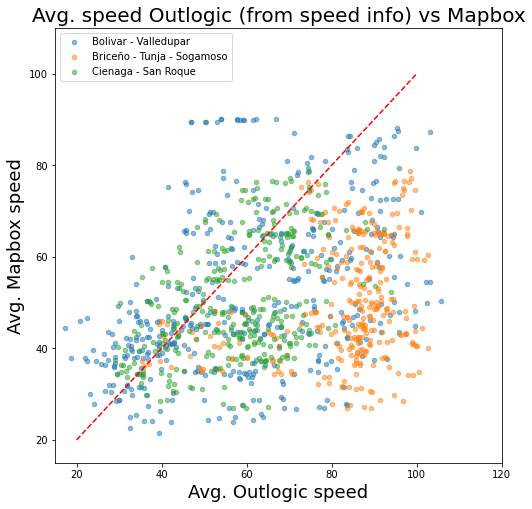

In [38]:
df_mean_speeds_id["ID_1"] = df_mean_speeds_id["ID_1"].astype(str)
df_dis["id_2"] = df_dis["id_2"].astype(str)

df_merge_id = df_mean_speeds_id.merge(df_dis, left_on = ["ID_1","hourTimeStamp"], right_on = ["id_2","hourTimeStamp"], how = "inner")

fig, ax = plt.subplots(figsize=(8,8))
for r in df_merge_id["Road_right"].unique():
    df_merge_id_r = df_merge_id[df_merge_id["Road_right"] == r]
    xx = df_merge_id_r["speed_x"]
    yy = df_merge_id_r["speed_y"]
    ax.scatter(xx,yy, label = name[r], alpha = 0.5, s = 20)
    
xx = np.linspace(20,100)
ax.plot(xx,xx, c = 'r', ls = "--")     
plt.title("Avg. speed Outlogic (from speed info) vs Mapbox", fontsize = 20)
plt.xlabel("Avg. Outlogic speed", fontsize = 18)
plt.ylabel("Avg. Mapbox speed", fontsize = 18)
plt.ylim(15,110), plt.xlim(15,120)
plt.legend()
plt.savefig("outputs/2022_11_informe/corr_from_speed_info_p85.png", dpi = 300)
plt.show()    

In [39]:
df_mean_speeds_id.to_csv("outputs/2022_11_informe/df_merge_id_fromVel_p85.csv", index = False)
df_mean_speeds_id

,Road_right,ID_1,hourTimeStamp,speed,speed_std
0,Bolivar_Valledupar,201,6,52.892692,16.091559
1,Bolivar_Valledupar,201,9,56.372326,12.720014
2,Bolivar_Valledupar,201,12,48.165407,15.234011
3,Bolivar_Valledupar,201,15,46.846176,16.440726
4,Bolivar_Valledupar,201,18,50.790692,16.467333
...,...,...,...,...,...
1664,Cienaga_San_Roque,102,6,61.534158,10.552299
1665,Cienaga_San_Roque,102,9,61.983234,11.436989
1666,Cienaga_San_Roque,102,12,64.322756,10.648465
1667,Cienaga_San_Roque,102,15,64.980970,9.842890


In [32]:
pearsonr(df_merge_id["speed_x"], df_merge_id["speed_y"])

PearsonRResult(statistic=0.33052787604835604, pvalue=1.253902199826009e-29)

In [26]:
stats.linregress(df_merge_id["speed_x"], df_merge_id["speed_y"])

LinregressResult(slope=0.2899225249728414, intercept=32.52389780446873, rvalue=0.3589923516136421, pvalue=7.371548720999216e-35, stderr=0.022726917309543054, intercept_stderr=1.4730892993380664)